In [ ]:
from deepom.figures import *

Images_FigureData().make_figure_data()

In [1]:
from deepom.figures import *

data = Images_FigureData.load_figure_data()

In [4]:
from matplotlib.ticker import MultipleLocator
from matplotlib_scalebar.scalebar import ScaleBar
import imageio
from skimage.exposure import rescale_intensity
data_item = data.data_item
item = data.item
refs = data.refs
inference_item = data.inference_item

scalebar_scale = 130e-9

In [70]:


im = item.crop_item.parent_bnx_item.bionano_image
im.read_jxr_image()
im = im.fov_image
im = rescale_intensity(im, in_range=(250, 600))
imageio.imwrite("../figures/fov_image.jpg", im)

Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.


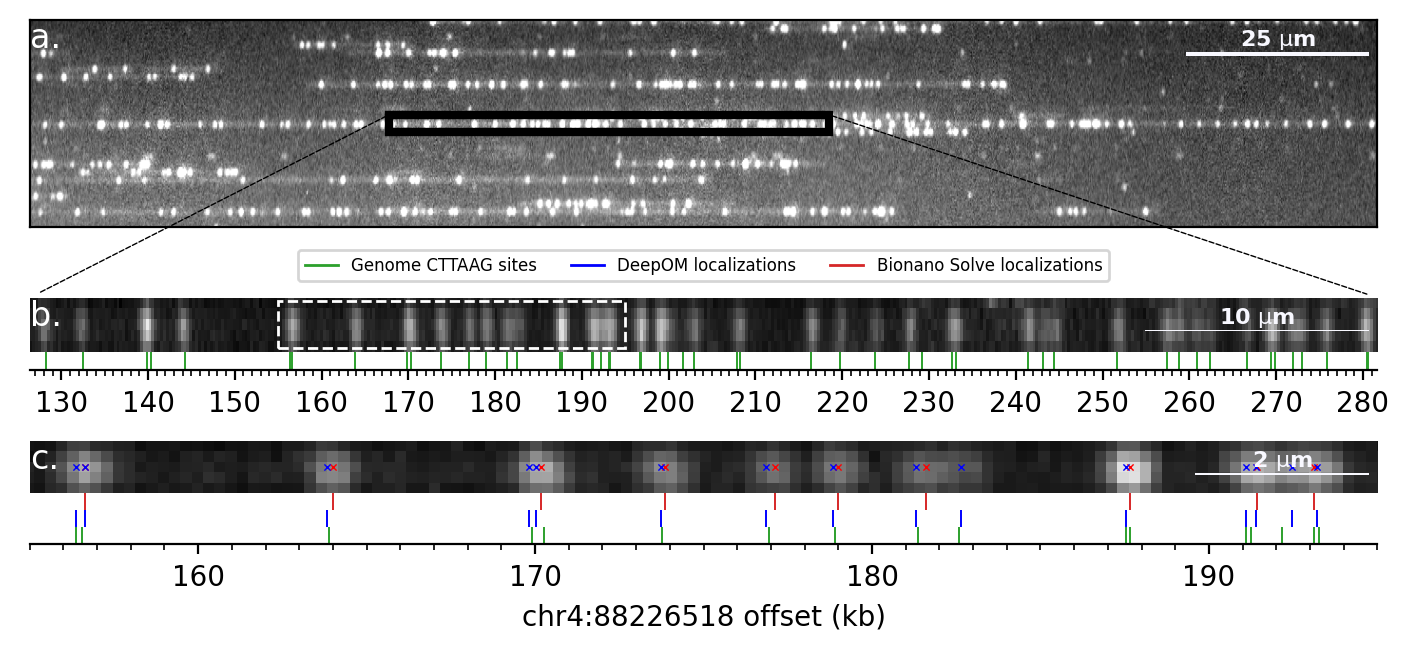

In [25]:
from pathlib import Path
from matplotlib.lines import Line2D
from matplotlib.patches import Patch, Rectangle, ConnectionPatch

_, axs = pyplot.subplots(figsize=(7, 3), dpi=200, nrows=3, gridspec_kw=dict(height_ratios=[2, .7, 1]))

titles = [
    "a.",
    "b.",
    "c.",
]
title_kw = dict(loc="left", y=1.0, pad=-10, fontdict={"color": "w"})
####################################################################
pyplot.sca(axs[0])
pyplot.title("a.", **title_kw)

fov_image = item.crop_item.parent_bnx_item.bionano_image.segment_image[0]
fov_margin = 40
fov_image = fov_image[fov_margin: -fov_margin]
fov_image = rescale_intensity(fov_image, in_range=(250, 600))
# pyplot.axhline(fov_image.shape[0] // 2, alpha=.2, color="b", lw=3)
pyplot.imshow(fov_image, cmap="gray", aspect="auto")

scalebar_kw = dict(color="ghostwhite", box_alpha=0, scale_loc="top", location="upper right", width_fraction=.02, sep=0,
                   font_properties=dict(weight="bold", size=8))
pyplot.gca().add_artist(ScaleBar(scalebar_scale, **scalebar_kw))

ax = pyplot.gca()
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

ilims = 29, 60
margin = 30e3

rvec = refs[item.ref_id]
qvec = item.qry_item.qry

lims = max(0, item.alignment_ref[ilims[0]] - margin), min(rvec.max(), item.alignment_ref[ilims[1]] + margin)
rvec_show = rvec[slice(*rvec.searchsorted(lims))]
offset = item.alignment_ref[ilims[0]] - item.alignment_qry[ilims[0]]
mol_offset = lims[0] - offset
scale = item.qry_item.scale

im_displ = item.qry_item.inference_item.image_input
im_displ = rescale_intensity(im_displ)

h = 10
x, y = (mol_offset / scale, fov_image.shape[0] // 2 - h / 2)
w = (lims[1] - lims[0]) / scale
rect0 = Rectangle((x, y), w, h, edgecolor='k', fill=False, linestyle="-", lw=3)
ax.add_patch(rect0)

pyplot.legend(
    [Line2D([0], [0], color=c, linewidth=1, linestyle='-') for c in ["tab:green", "b", "tab:red"]],
    ["Genome CTTAAG sites", "DeepOM localizations", "Bionano Solve localizations"],
    ncol=3, loc="lower center",
    fontsize=6,
    bbox_to_anchor=(0.5, -.3)
)
####################################################################
pyplot.sca(axs[1])

pyplot.title("b.", **title_kw)

bionano_locs = item.crop_item.pixel_locs * scale
locs = item.alignment_qry
scatter_kw = dict(marker="x", s=5, alpha=1, linewidths=.5)


def plot_molecule():
    pyplot.imshow(im_displ[::-1], cmap='gray', extent=[0, im_displ.shape[-1] * scale, 3, 6], aspect="auto", interpolation="none")
    set_only_x_visible()
    set_formatter(lambda x, _: int(x / 1000))

    pyplot.gca().add_artist(ScaleBar(scalebar_scale / scale, **scalebar_kw))


plot_molecule()

zoom_lims = 155 * 1000, 195 * 1000

ax = pyplot.gca()
margin_rect = .2
rect1 = Rectangle((zoom_lims[0], 3 + margin_rect), (zoom_lims[1] - zoom_lims[0]), 3 - margin_rect * 2,
                  edgecolor='w', fill=False, linestyle="--")
ax.add_patch(rect1)

ax = pyplot.gca()
ax.xaxis.set_major_locator(MultipleLocator(10000))
ax.xaxis.set_minor_locator(MultipleLocator(1000))

ref_sites = rvec_show - offset
linewidths = .7
pyplot.eventplot([ref_sites],
                 lineoffsets=[2.5], colors=["tab:green"],
                 linelengths=[1], linewidths=linewidths)

pyplot.xlim(lims[0] - offset, lims[1] - offset)
pyplot.ylim(2, None)
####################################################################
pyplot.sca(axs[2])

ax = pyplot.gca()
ax.xaxis.set_major_locator(MultipleLocator(10000))
ax.xaxis.set_minor_locator(MultipleLocator(1000))

pyplot.title("c.", **title_kw)
pyplot.scatter(bionano_locs, [4.5] * len(bionano_locs), c="r", **scatter_kw)
pyplot.scatter(locs, [4.5] * len(locs), c="b", **scatter_kw)

pyplot.eventplot([ref_sites, locs, bionano_locs],
                 lineoffsets=[.5, 1.5, 2.5], colors=["tab:green", "b", "tab:red"],
                 linelengths=[1, 1, 1], linewidths=linewidths)

plot_molecule()
pyplot.xlim(*zoom_lims)

pyplot.ylim(0, None)
pyplot.tight_layout(pad=.5)
pyplot.xlabel(f"chr{item.ref_id}:{int(offset)} offset (kb)")
fig = pyplot.gcf()
arrow_kw = dict(
    coordsA=axs[0].transData,
    coordsB=axs[1].transAxes,
    shrinkA=1,
    shrinkB=4,
    color="black",
    linestyle="--",
    arrowstyle="-",
    mutation_scale=10,
    linewidth=.5,
)
x, y = rect0.xy
w = rect0.get_width()
fig.patches.extend([ConnectionPatch((x, y), (0, 1), **arrow_kw), ConnectionPatch((x + w, y), (1, 1), **arrow_kw)])

for ext in [".pdf"]:
    pyplot.savefig(Path("../../DeepOM-Paper/figures") / ("images_figure" + ext), bbox_inches='tight')